In [1]:
from stepmix.stepmix import StepMix
import pandas as pd
import numpy as np
# import ParameterGrid
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pkl


In [2]:
df = pd.read_csv("../../data/cleaned_data_SYMPTOMS_9_13_23.csv", index_col=0)
sympdf = df.loc[:, df.columns.str.startswith('Symptom_')].copy()
sympdf.shape

(6031, 162)

In [3]:
groups_df = pd.read_csv('../output/symptom_groups.csv')


In [4]:
groups_df

,symptom,group
0,Symptom_Memory_short,Memory
1,Symptom_Memory_long,Memory
2,Symptom_Memory_no_new_memories,Memory
3,Symptom_Memory_forget_tasks,Memory
4,Symptom_Memory_other,Memory
...,...,...
156,Symptom_Neuralgia,Misc
157,Symptom_Pain_burning_chest,Misc
158,Symptom_Eye_Vision_pink_eye,Misc
159,Symptom_Eye_Vision_bloodshot_eyes,Misc


In [5]:
clus = pd.read_csv("../../clusterings/tessa/cluster_13_111023.csv", index_col=0)
clus_leo = pd.read_csv("../../clusterings/leo/final_aencoder_hdbscan_6.csv", index_col=0)
clus_chris = pd.read_csv("../../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_8.csv", index_col=0)

In [6]:
ensemble = pd.concat([clus['cluster'].rename("LCA"), clus_leo['cluster'].rename("Leo"), clus_chris['cluster'].rename("Chris")], axis=1)

In [7]:
sympdf['LCA'] = clus['cluster'].values
sympdf['Leo'] = clus_leo['cluster'].values
sympdf['Chris'] = clus_chris['cluster'].values

In [8]:
avg_scores_by_grouping = {}
def make_avg_scores_by_grouping(sympdf = sympdf, clustercol = 'cluster', groups_df=groups_df):
    for grouping in groups_df.group.unique():
        # calculat the average score for each symptom in the group for each cluster in 'cluster'
        keepcols = groups_df.loc[groups_df.group == grouping, 'symptom'].tolist()
        #print(keepcols)
        keepcols.append(clustercol)
        a = sympdf.loc[:, keepcols]
        avg = a.groupby(clustercol).mean()
        avg_scores_by_grouping[grouping] = avg.mean(axis=1)
        #avg = sympdf.loc[:, sympdf.columns.str.startswith(grouping)].groupby(clus).mean()
    return(pd.DataFrame(avg_scores_by_grouping))


In [9]:
tessadf = make_avg_scores_by_grouping(clustercol = "LCA")

In [10]:
chrisdf = make_avg_scores_by_grouping(clustercol="Chris")

In [11]:
leodf = make_avg_scores_by_grouping(clustercol="Leo")

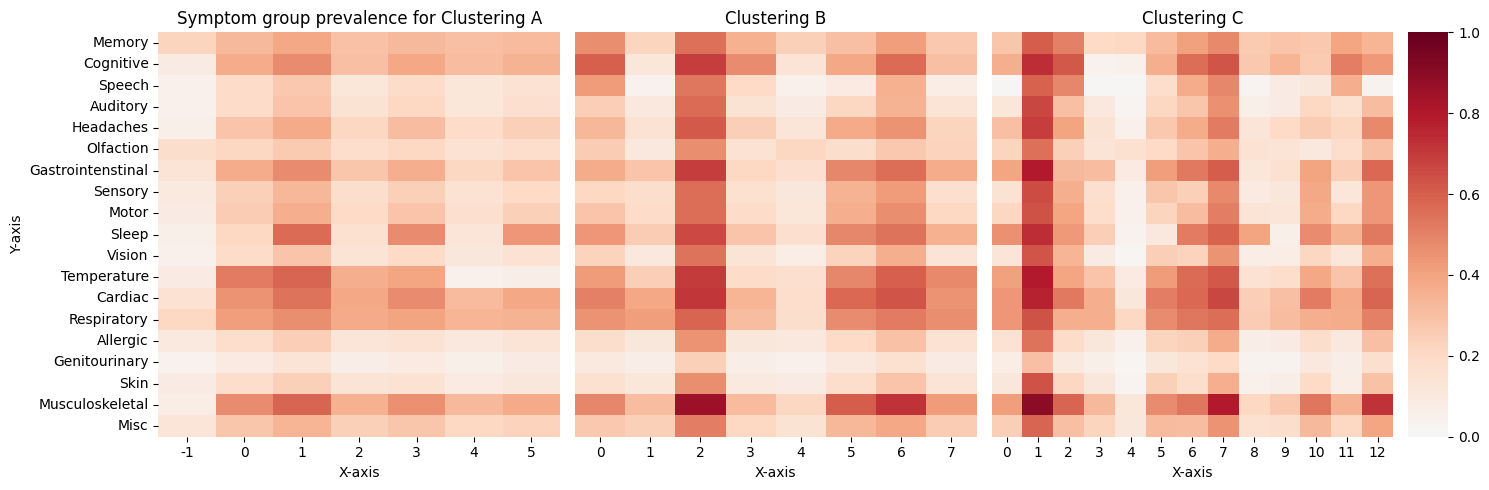

<Figure size 640x480 with 0 Axes>

In [13]:
# Rotate data 
data2 = chrisdf.T
data1 = leodf.T
data3 = tessadf.T

cmap = "RdBu_r"
# Create a figure and a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
# Plot the first heatmap using Seaborn
sns.heatmap(data1, cmap=cmap, ax=axs[0], center = 0, cbar=False, vmin=0, vmax=1)
axs[0].set_title('Symptom group prevalence for Clustering A')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

# Plot the second heatmap 
sns.heatmap(data2, cmap=cmap, ax=axs[1],center = 0 , cbar=False, vmin=0, vmax=1)
axs[1].set_title('Clustering B')
axs[1].set_xlabel('X-axis')
axs[1].set_yticks([])  # Remove y-axis ticks for shared y-axis

# Plot the third heatmap 
sns.heatmap(data3, cmap=cmap, ax=axs[2], center=0, cbar_ax=axs[3], vmin=0, vmax=1)
axs[2].set_title('Clustering C')
axs[2].set_xlabel('X-axis')
axs[2].set_yticks([])  # Remove y-axis ticks for shared y-axis

# Adjust layout
plt.tight_layout()

plt.show()

plt.savefig('../figs/combined_group_prevalence_scaled.pdf')

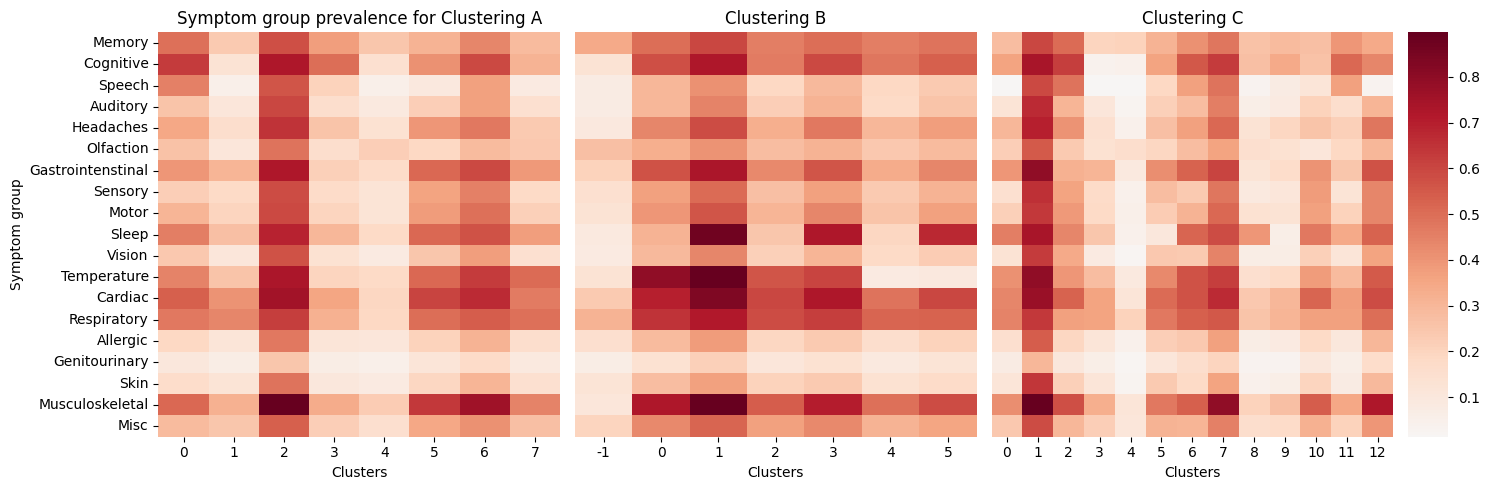

<Figure size 640x480 with 0 Axes>

In [14]:
# Generate some example data
data1 = chrisdf.T
data2 = leodf.T
data3 = tessadf.T

cmap = "RdBu_r"
# Create a figure and a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
# Plot the first heatmap using Seaborn
sns.heatmap(data1, cmap=cmap, ax=axs[0], center = 0, cbar=False)
axs[0].set_title('Symptom group prevalence for Clustering A')
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Symptom group')

# Plot the second heatmap using Seaborn
sns.heatmap(data2, cmap=cmap, ax=axs[1],center = 0 , cbar=False)
axs[1].set_title('Clustering B')
axs[1].set_xlabel('Clusters')
axs[1].set_yticks([])  # Remove y-axis ticks for shared y-axis

# Plot the third heatmap using Seaborn
sns.heatmap(data3, cmap=cmap, ax=axs[2], center=0, cbar_ax=axs[3])
axs[2].set_title('Clustering C')
axs[2].set_xlabel('Clusters')
axs[2].set_yticks([])  # Remove y-axis ticks for shared y-axis

# Adjust layout
plt.tight_layout()

plt.show()

plt.savefig('../figs/combined_group_prevalence.pdf')

In [15]:
# chris to add UMAP/tSNE 

In [16]:
ensemble = pd.concat([clus_leo['cluster'].rename("clus_A"), clus_chris['cluster'].rename("clus_B"), clus['cluster'].rename("clus_C")], axis=1)

In [17]:
for l in ["A","B","C"]:
    ensemble['clus_'+l] = l + ensemble['clus_'+l].astype("str")

In [18]:
overlaps_AB_agg = ensemble.groupby("clus_A")['clus_B'].value_counts().unstack(fill_value=0)
overlaps_AC_agg = ensemble.groupby("clus_A")['clus_C'].value_counts().unstack(fill_value=0)
overlaps_BC_agg = ensemble.groupby("clus_B")['clus_C'].value_counts().unstack(fill_value=0)


In [19]:
desired_order = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']
overlaps_AC_agg = overlaps_AC_agg[desired_order]
overlaps_BC_agg = overlaps_BC_agg[desired_order]

In [20]:
overlaps_AC_agg.rename(index={"A-1":"AX"}, inplace=True)

In [21]:
overlaps_AB_agg.rename(index={"A-1":"AX"}, inplace=True)

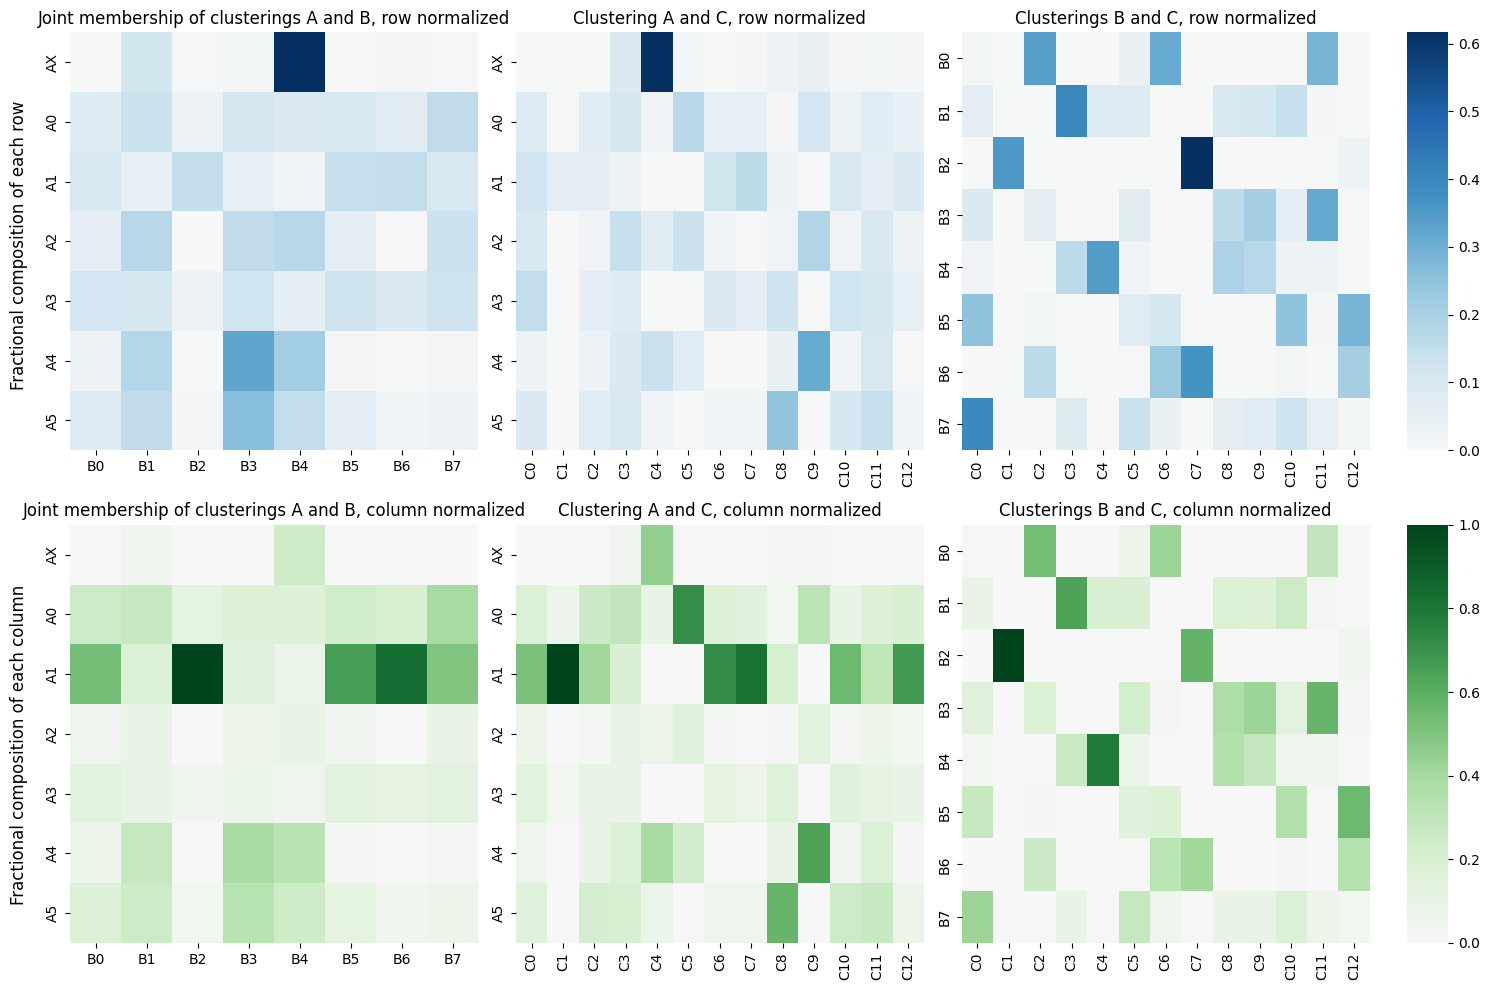

In [57]:
data1 = overlaps_AB_agg.div(overlaps_AB_agg.sum(axis=1), axis=0)
data2 = overlaps_AC_agg.div(overlaps_AC_agg.sum(axis=1), axis=0)
data3 = overlaps_BC_agg.div(overlaps_BC_agg.sum(axis=1), axis=0)
data4 = overlaps_AB_agg.div(overlaps_AB_agg.sum(axis=0), axis=1)
data5 = overlaps_AC_agg.div(overlaps_AC_agg.sum(axis=0), axis=1)
data6 = overlaps_BC_agg.div(overlaps_BC_agg.sum(axis=0), axis=1)

cmap = "RdBu"
cmap2 = "PRGn"

# Create a figure and a 1x4 grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
# Plot the first heatmap using Seaborn
sns.heatmap(data1, cmap=cmap, ax=axs[0,0], center = 0, cbar=False)
axs[0,0].set_title('Joint membership of clusterings A and B, row normalized')
axs[0,0].set_xlabel(None)
axs[0,0].set_ylabel(None)

# Plot the second heatmap using Seaborn
sns.heatmap(data2, cmap=cmap, ax=axs[0,1],center = 0 , cbar=False)
axs[0,1].set_title('Clustering A and C, row normalized')
axs[0,1].set_xlabel(None)
axs[0,1].set_ylabel(None)

# Plot the third heatmap using Seaborn
sns.heatmap(data3, cmap=cmap, ax=axs[0,2], center=0, cbar_ax=axs[0,3])
axs[0,2].set_title('Clusterings B and C, row normalized')
axs[0,2].set_xlabel(None)
axs[0,2].set_ylabel(None)
#axs[2].set_xlabel('Clusters')

sns.heatmap(data4, cmap=cmap2, ax=axs[1,0], center = 0, cbar=False)
axs[1,0].set_title('Joint membership of clusterings A and B, column normalized')
axs[1,0].set_xlabel(None)
axs[1,0].set_ylabel(None)
#axs[0].set_xlabel('Clusters')
#axs[0].set_ylabel('Symptom group')

# Plot the second heatmap using Seaborn
sns.heatmap(data5, cmap=cmap2, ax=axs[1,1],center = 0 , cbar=False)
axs[1,1].set_title('Clustering A and C, column normalized')
axs[1,1].set_xlabel(None)
axs[1,1].set_ylabel(None)
#axs[1].set_xlabel('Clusters')

# Plot the third heatmap using Seaborn
sns.heatmap(data6, cmap=cmap2, ax=axs[1,2], center=0, cbar_ax=axs[1,3])
axs[1,2].set_title('Clusterings B and C, column normalized')
axs[1,2].set_xlabel(None)
axs[1,2].set_ylabel(None)
#axs[2].set_xlabel('Clusters')

# Add subtitles
fig.text(0.01, 0.75, 'Fractional composition of each row', va='center', fontsize=12, rotation='vertical')
fig.text(0.01, 0.25, 'Fractional composition of each column', va='center', fontsize=12, rotation='vertical')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.05)

plt.show()

#plt.savefig("../figs/joint_membership_ABC.pdf")

In [55]:
data5

clus_C,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12
clus_A,,,,,,,,,,,,,
AX,0.000000,0.005618,0.000000,0.043716,0.406170,0.011364,0.002227,0.005515,0.018367,0.022472,0.005894,0.006579,0.008021
A0,0.164634,0.061798,0.228070,0.260474,0.092545,0.639205,0.158129,0.137868,0.034694,0.275281,0.080550,0.154605,0.176471
A1,0.457317,0.898876,0.370927,0.171220,0.007712,0.000000,0.648107,0.733456,0.183673,0.000000,0.493124,0.268092,0.606952
A2,0.057927,0.000000,0.025063,0.094718,0.066838,0.139205,0.017817,0.005515,0.020408,0.127341,0.017682,0.059211,0.032086
A3,0.132622,0.028090,0.095238,0.083789,0.000000,0.000000,0.111359,0.064338,0.151020,0.000000,0.137525,0.100329,0.085561
A4,0.050305,0.000000,0.087719,0.162113,0.352185,0.210227,0.006682,0.003676,0.079592,0.569288,0.047151,0.167763,0.021390
A5,0.137195,0.005618,0.192982,0.183971,0.074550,0.000000,0.055679,0.049632,0.512245,0.005618,0.218075,0.243421,0.069519
